# Figure Generation Notebook - SplicingIndex figure

This notebook creates a single figure, SplicingIndexFigure a plot showing the number of AS events per 1000 exons for each chromosome

## Figures (PDF files) created by this notebook
Output PDF Figures are written to the ``pdf/`` directory.

**tissue-piechart.pdf**: Plot showing number of tissues-per gene with AS events


In [2]:
defaultW <- getOption("warn")  # suppress warnings for this cell
options(warn = -1) 

library(dplyr)
library(ggplot2)
library(limma)
library(multtest)
library(Biobase)
library(edgeR)
library(tibble)
library(R.utils)
library(rtracklayer)

options(warn = defaultW)

## 1. Download all the rMATS results

Each of the alternative splicing output files are downloaded here:

### 1.1 get released rMATS GTF annotations

For each splicing type, the junctions are defined, so we have 5 specific annotated splicing specific junction ID annotation files:

1. **fromGTF.A3SS.txt**: annotations for the alternative 3' splice site junctions
2. **fromGTF.A5SS.txt**: annotations for the alternative 5' splice site junctions
3. **fromGTF.MXE.txt**: annotations for the mutually exclusive exon junctions
4. **fromGTF.RI.txt**: annotations for the retained introns junctions
5. **fromGTF.SE.txt**: annotations for the skipped exon junctions

## 1.2 Unpacked the data.tar file if necessaty

In [3]:
dge_splicing_file_dir <- list.files("../../mounted-data", pattern='DGE_splicing_data.tar.gz')
dge_splicing_file <- paste("../../mounted-data", dge_splicing_file_dir, 'robinson-bucket/notebooks/DGE_splicing_data', sep='/')
dge_splicing_file_tar_gz <- paste(dge_splicing_file, '.tar.gz', sep='')
example_unpacked_file = '../data/ri_brain_cerebellum_DGE_sex.csv'
if (! file.exists(example_unpacked_file)) {
    mycommand = paste("tar xvfz ",dge_splicing_file_tar_gz, "-C ../data", sep=" ")
    message(mycommand)
    system(mycommand, intern = TRUE)
    message("Done unpacking ", dge_splicing_file_tar_gz)
} else {
    message("Cowardly refusing to unpack ", dge_splicing_file_tar_gz, " since it was previously unapcked")
}




tar xvfz  ../../mounted-data//robinson-bucket/notebooks/DGE_splicing_data.tar.gz -C ../data

Warning message in system(mycommand, intern = TRUE):
“running command 'tar xvfz  ../../mounted-data//robinson-bucket/notebooks/DGE_splicing_data.tar.gz -C ../data' had status 2”
Done unpacking ../../mounted-data//robinson-bucket/notebooks/DGE_splicing_data.tar.gz



In [4]:
data_file_dir <- list.files("../../mounted-data", pattern='-data.tar.gz')
data_file_tar_gz <- paste("../../mounted-data", data_file_dir, 'robinson-bucket/notebooks/data.tar.gz', sep='/')
example_unpacked_file = '../data/SraRunTable.txt.gz'
if (! file.exists(example_unpacked_file)) {
    mycommand = paste("tar xvfz ",data_file_tar_gz, "-C ../data", sep=" ")
    message(mycommand)
    system(mycommand, intern = TRUE)
    message("Done unpacking ", data_file_tar_gz)
} else {
    message("Cowardly refusing to unpack ", data_file_tar_gz, " since it was previously unapcked")
}


Cowardly refusing to unpack ../../mounted-data//robinson-bucket/notebooks/data.tar.gz since it was previously unapcked



In [5]:
getReleasedGTFAnnotations <- function ( destDir ) {
    message("Decompressing fromGTF.tar.gz into ../data")
    system("mkdir -p ../data && tar xvfz ../data/fromGTF.tar.gz -C ../data", intern = TRUE)
    message("Done!\n")
    message("Gunzipping files into ../data")
    system("gunzip ../data/fromGTF.*txt.gz", intern = TRUE)
    message("Done!\n")
}

#
# 1.2.2 get the rmats 3.2.5 discovered/annoated junction information in GTF format
#
getReleasedGTFAnnotations (destDir <- "../data/")

Decompressing fromGTF.tar.gz into ../data

Done!


Gunzipping files into ../data

Warning message in system("gunzip ../data/fromGTF.*txt.gz", intern = TRUE):
“running command 'gunzip ../data/fromGTF.*txt.gz' had status 2”
Done!




### 2  Refined results
We define **refined results* as (FC > 1.5 and pVal < 0.05) for the sex\*as_event coefficient result for the linear model

### 2.1 getTissueReduction

In [6]:
getTissueReduction <- function ( filename ) {

    tissue_reduction <- read.table(filename, header=TRUE, sep="\t",
                               skipNul=FALSE, stringsAsFactors = FALSE)
    colnames(tissue_reduction)  <- c("SMTSD","female","male","include","display_name")

    return(tissue_reduction)
}
tissue_reduction <- getTissueReduction ("../assets/tissues.tsv")

### 2.2 Read in refined results and annotations

In [16]:
significant_results_dir = "../data/"
pattern = "AS_model_B_sex_as_events_refined.csv"
files <- list.files(path = significant_results_dir, pattern = pattern)
as_types <- c("a3ss", "a5ss", "mxe", "ri", "se")

In [17]:
a3ss_annot <- read.table(file = "../data/fromGTF.A3SS.txt", sep = "\t", quote = "\"", header = T, stringsAsFactors = F)
a5ss_annot <- read.table(file = "../data/fromGTF.A5SS.txt", sep = "\t", quote = "\"", header = T, stringsAsFactors = F)
mxe_annot <- read.table(file = "../data/fromGTF.MXE.txt", sep = "\t", quote = "\"", header = T, stringsAsFactors = F)
ri_annot <- read.table(file = "../data/fromGTF.RI.txt", sep = "\t", quote = "\"", header = T, stringsAsFactors = F)
se_annot <- read.table(file = "../data/fromGTF.SE.txt", sep = "\t", quote = "\"", header = T, stringsAsFactors = F)

In [19]:
message("We found ", length(files), " AS_model_B_sex_as_events_refined files")

We found 195 AS_model_B_sex_as_events_refined files



In [20]:
gene_as = data.frame()
counts <- rep(NA, length(files))
ASE <- rep("NA", length(files))
Tissue <- rep("NA", length(files))

for (i in 1:length(files)) {
    lines <- read.csv(paste0(significant_results_dir, files[i]),header = TRUE)
    event     <- as.vector(as.character(rownames(lines)))
    tissue <- gsub("_DGE_sex_as_events_refined.csv","", files[i], fixed = TRUE)

    counts[i] <- dim(lines)[1]
    
    if (dim(lines)[1] > 0) { #has significant events
        # rownames of the significant results file are a combination of gene-symbol and junction name
        # using a regular expression - extract the last numbers that then are the index to the annotation table
        event_idx <- substring(event, regexpr("[0-9]+$", event))
        
        if (grepl("a3ss_", files[i])) {
            tissue <- gsub("a3ss_","", tissue, fixed = TRUE)
            ASE[i] <- "A3SS"
            Tissue[i] <- tissue
            idx <- match(event_idx, a3ss_annot$ID)
            res <- data.frame(GeneJunction = event,
                              ASE = "A3SS", 
                              ASE_IDX = idx,
                              Tissue = tissue, 
                              GeneSymbol = a3ss_annot$geneSymbol[idx],
                              chr = a3ss_annot$chr[idx])
        }
        if (grepl("a5ss_", files[i])) {
            tissue <- gsub("a5ss_","", tissue, fixed = TRUE)
            ASE[i] <- "A5SS"
            Tissue[i] <- tissue
            idx <- match(event_idx, a5ss_annot$ID)
            res <- data.frame(GeneJunction = event,
                              ASE = "A5SS", 
                              ASE_IDX = idx,
                              Tissue = tissue, 
                              GeneSymbol = a5ss_annot$geneSymbol[idx],
                              chr = a5ss_annot$chr[idx])
        }
        if (grepl("mxe_", files[i])) {
            ASE[i] <- "MXE"
            tissue <- gsub("mxe_","", tissue, fixed = TRUE)
            Tissue[i] <- tissue
            idx <- match(event_idx, a3ss_annot$ID)
            res <- data.frame(GeneJunction = event,
                              ASE = "MXE", 
                              ASE_IDX = idx,
                              Tissue = tissue, 
                              GeneSymbol = mxe_annot$geneSymbol[idx],
                              chr = mxe_annot$chr[idx])
        }
        if (grepl("se_", files[i])) {
            ASE[i] <- "SE"
            tissue <- gsub("se_","", tissue, fixed = TRUE)
            Tissue[i] <- tissue
            idx <- match(event_idx, se_annot$ID)
            res <- data.frame(GeneJunction = event,
                              ASE = "SE", 
                              ASE_IDX = idx,
                              Tissue = tissue, 
                              GeneSymbol = se_annot$geneSymbol[idx],
                              chr = se_annot$chr[idx])
        }
        if (grepl("ri_", files[i])){
            ASE[i] <- "RI"
            tissue <- gsub("ri_","", tissue, fixed = TRUE)
            Tissue[i] <- tissue
            idx <- match(event_idx, ri_annot$ID)
            res <- data.frame(GeneJunction = event,
                              ASE = "RI", 
                              ASE_IDX = idx,
                              Tissue = tissue, 
                              GeneSymbol = ri_annot$geneSymbol[idx],
                              chr = a3ss_annot$chr[idx])
        }
        gene_as <- rbind(gene_as, res)
        
    } #if has sig. events
    
} #for all files
message ("\nDone reading significant events!\n")


Done reading significant events!




### 3 Data Structures for Figures

### 3.1 gene_as.tsv

This file contains (description)
Here is a typical line
<pre>
        GeneJunction    ASE     ASE_IDX Tissue  GeneSymbol      chr
1       MDM4-3553       SE      3553    adipovisceral_omentum   RNPEP   chr1
2       WDR17-8668      SE      8668    adipovisceral_omentum   ANKMY1  chr2
3       IL17RC-5032     SE      5032    adipovisceral_omentum   SNCAIP  chr5
4       DDX3X-5712      A3SS    5712    adrenal_gland   DDX3X   chrX
</pre>
There are 2848 significant events in the file.

In [21]:
glimpse(gene_as)
table(is.na(gene_as$Tissue))
colnames(gene_as)
write.table(gene_as, "../data/gene_as.tsv", quote=FALSE, sep="\t")
head(gene_as)

Observations: 6,370
Variables: 6
$ GeneJunction <fct> XIST-2253, XIST-2252, GREB1L-4933, RHCG-1776, XIST-2253,…
$ ASE          <fct> SE, SE, SE, SE, SE, SE, SE, SE, SE, SE, SE, SE, SE, SE, …
$ ASE_IDX      <int> 2253, 2252, 4933, 1776, 2253, 2252, 4819, 4818, 4820, 45…
$ Tissue       <fct> adiposubcutaneous_AS_model_B_sex_as_events_refined.csv, …
$ GeneSymbol   <fct> DLEU1, DLEU1, AKT1, MLF1, DLEU1, DLEU1, CNN2, KCNK7, CNN…
$ chr          <fct> chr13, chr13, chr14, chr3, chr13, chr13, chr19, chr11, c…



FALSE 
 6370 

[1] "GeneJunction" "ASE"          "ASE_IDX"      "Tissue"       "GeneSymbol"  
[6] "chr"

,GeneJunction,ASE,ASE_IDX,Tissue,GeneSymbol,chr
,<fct>,<fct>,<int>,<fct>,<fct>,<fct>
1,XIST-2253,SE,2253,adiposubcutaneous_AS_model_B_sex_as_events_refined.csv,DLEU1,chr13
2,XIST-2252,SE,2252,adiposubcutaneous_AS_model_B_sex_as_events_refined.csv,DLEU1,chr13
3,GREB1L-4933,SE,4933,adiposubcutaneous_AS_model_B_sex_as_events_refined.csv,AKT1,chr14
4,RHCG-1776,SE,1776,adiposubcutaneous_AS_model_B_sex_as_events_refined.csv,MLF1,chr3
5,XIST-2253,SE,2253,adipovisceral_omentum_AS_model_B_sex_as_events_refined.csv,DLEU1,chr13
6,XIST-2252,SE,2252,adipovisceral_omentum_AS_model_B_sex_as_events_refined.csv,DLEU1,chr13


### 3.2 Tissue specific data frame

In [22]:
sum(Tissue == "NA")
data <- data.frame(Tissue = Tissue, ASE = ASE, Counts = counts)
data <- data[!(Tissue=="NA"),]
numberOfUniqueTissues <- length(summary(as.factor(data$Tissue),maxsum=500))
numberOfASEmechanisms <- length(summary(as.factor(data$ASE),maxsum=500))
message("data now has ",numberOfUniqueTissues, " tissues and ", numberOfASEmechanisms, " ASE categories")
message("ASE:")
summary(as.factor(data$ASE),maxsum=500)

[1] 41

data now has 40 tissues and 6 ASE categories

ASE:



A3SS A5SS  MXE   NA   RI   SE 
  36   24   26    0   21   47

### 3.3 Count splicing event by chromosome

Count the number of significant alternative splicing events per chromosome and write to the file **Total_AS_by_chr.tsv**.

In [23]:
res2 <- gene_as          %>% 
       group_by(chr)    %>% 
       count(chr)       %>% 
       arrange(desc(n)) %>% 
       as.data.frame()
res2$chr <- factor(res2$chr, levels = res2$chr)
length(res2$chr)
res2
glimpse(res2)
write.table(res2, file= "../data/Total_AS_by_chr.tsv", sep="\t", quote = FALSE, row.names=F)

[1] 23

chr,n
<fct>,<int>
chrX,762
chr1,631
chr19,433
chr11,388
chr3,381
chr2,376
chr17,360
chr12,333
chr16,305


Observations: 23
Variables: 2
$ chr <fct> chrX, chr1, chr19, chr11, chr3, chr2, chr17, chr12, chr16, chr4, …
$ n   <int> 762, 631, 433, 388, 381, 376, 360, 333, 305, 290, 248, 238, 217, …


### 3.4 Count most frequent spliced genes 

In [24]:
res3 <- gene_as %>% 
       group_by(GeneSymbol) %>% count(GeneSymbol) %>% arrange(desc(n)) %>% as.data.frame()
res3$GeneSymbol <- factor(res3$GeneSymbol, levels = res3$GeneSymbol)
length(res3$GeneSymbol)
head(res3)
write.table(res3, file = "../data/Total_AS_by_geneSymbol.tsv", sep = "\t", quote=FALSE, row.names = F)

[1] 2899

,GeneSymbol,n
,<fct>,<int>
1,XIST,335
2,DDX3X,96
3,KDM5C,47
4,ZFX,47
5,KDM6A,27
6,UCA1,25


### 3.5 Count most frequent splicing by tissue

In [25]:
res4 <- gene_as %>% 
       group_by(Tissue) %>% 
       count(Tissue) %>% 
       arrange(desc(n)) %>% 
       as.data.frame()
res4$Tissue <- factor(res4$Tissue, levels = res4$Tissue)
length(res4$Tissue)
res4
write.table(res4, file = "../data/Total_AS_by_tissue.tsv", sep = "\t", row.names = F)

[1] 39

Tissue,n
<fct>,<int>
breast_mammary_tissue_AS_model_B_sex_as_events_refined.csv,4361
brain_nucleus_accumbens_basal_ganglia_AS_model_B_sex_as_events_refined.csv,335
esophagus_muscularis_AS_model_B_sex_as_events_refined.csv,261
artery_aorta_AS_model_B_sex_as_events_refined.csv,139
thyroid_AS_model_B_sex_as_events_refined.csv,104
cells_cultured_fibroblasts_AS_model_B_sex_as_events_refined.csv,97
muscle_skeletal_AS_model_B_sex_as_events_refined.csv,80
adiposubcutaneous_AS_model_B_sex_as_events_refined.csv,78
pituitary_AS_model_B_sex_as_events_refined.csv,65


###  3.6 Significant Count by splicing type 
We define **significant** to be FC > 1.5 and pVal < 0.05

Our starting values were the significant events, all meeting the criteria FC > 1.5 and pVal < 0.05


In [26]:
res5 <- gene_as %>% group_by(ASE) %>% count(ASE) %>% arrange(desc(n)) %>% as.data.frame()
res5$ASE <- factor(res5$ASE, levels = res5$ASE)
head(res5)
write.table(res5, file= "../data/Total_AS_by_splicingtype.tsv")

,ASE,n
,<fct>,<int>
1,SE,4675
2,A3SS,675
3,RI,418
4,A5SS,409
5,MXE,193


###  3.7 Significant Count by splicing type (significant == FC > 1.5 and pVal < 0.05)

In [27]:
A3SS_keep <- as.character(gene_as$ASE) %in% "A3SS"
table(A3SS_keep)
A3SS.gene_as <- data.frame(gene_as[A3SS_keep == TRUE,])

A5SS_keep <- as.character(gene_as$ASE) %in% "A5SS"
table(A5SS_keep)
A5SS.gene_as <- data.frame(gene_as[A5SS_keep == TRUE,])

MXE_keep  <- as.character(gene_as$ASE) %in% "MXE"
table(MXE_keep)
MXE.gene_as <- data.frame(gene_as[MXE_keep == TRUE,])

SE_keep   <- as.character(gene_as$ASE) %in% "SE"
table(SE_keep)
SE.gene_as <- data.frame(gene_as[SE_keep == TRUE,])

RI_keep   <- as.character(gene_as$ASE) %in% "RI"
table(RI_keep)
RI.gene_as <- data.frame(gene_as[RI_keep == TRUE,])

dim(A3SS.gene_as)
dim(A5SS.gene_as)
dim(MXE.gene_as)
dim(SE.gene_as)
dim(RI.gene_as)


A3SS_keep
FALSE  TRUE 
 5695   675 

A5SS_keep
FALSE  TRUE 
 5961   409 

MXE_keep
FALSE  TRUE 
 6177   193 

SE_keep
FALSE  TRUE 
 1695  4675 

RI_keep
FALSE  TRUE 
 5952   418 

[1] 675   6

[1] 409   6

[1] 193   6

[1] 4675    6

[1] 418   6

### 3.8 Siginficant spliced by Gene for each splicing factor

In [28]:
A3SS.res <- A3SS.gene_as %>% group_by(GeneSymbol) %>% count(GeneSymbol) %>% arrange(desc(n)) %>% as.data.frame()
A3SS.res$GeneSymbol <- factor(A3SS.res$GeneSymbol, levels = A3SS.res$GeneSymbol)
message("Significant spliced genes for A3SS\n",
        paste(length(A3SS.res$GeneSymbol)), collapse=" ")
head(A3SS.res)

A5SS.res <- A5SS.gene_as %>% group_by(GeneSymbol) %>% count(GeneSymbol) %>% arrange(desc(n)) %>% as.data.frame()
A5SS.res$GeneSymbol <- factor(A5SS.res$GeneSymbol, levels = A5SS.res$GeneSymbol)
message("Significant spliced genes for A5SS\n",
        paste(length(A5SS.res$GeneSymbol)), collapse=" ")
head(A5SS.res)

MXE.res <- MXE.gene_as %>% group_by(GeneSymbol) %>% count(GeneSymbol) %>% arrange(desc(n)) %>% as.data.frame()
MXE.res$GeneSymbol <- factor(MXE.res$GeneSymbol, levels = MXE.res$GeneSymbol)
message("Significant spliced genes for MXE\n",
        paste(length(MXE.res$GeneSymbol)), collapse=" ")
head(MXE.res)

RI.res <- RI.gene_as %>% group_by(GeneSymbol) %>% count(GeneSymbol) %>% arrange(desc(n)) %>% as.data.frame()
RI.res$GeneSymbol <- factor(RI.res$GeneSymbol, levels = RI.res$GeneSymbol)
message("Significant spliced genes for RI\n",
        paste(length(RI.res$GeneSymbol)), collapse=" ")
head(RI.res)

SE.res <- SE.gene_as %>% group_by(GeneSymbol) %>% count(GeneSymbol) %>% arrange(desc(n)) %>% as.data.frame()
SE.res$GeneSymbol <- factor(SE.res$GeneSymbol, levels = SE.res$GeneSymbol)
message("Significant spliced genes for SE\n",
        paste(length(SE.res$GeneSymbol)), collapse=" ")
head(SE.res)

Significant spliced genes for A3SS
450 



,GeneSymbol,n
,<fct>,<int>
1,XIST,71
2,DDX3X,21
3,UCA1,11
4,HAND2-AS1,7
5,NDRG4,6
6,STRA6,5


Significant spliced genes for A5SS
325 



,GeneSymbol,n
,<fct>,<int>
1,DDX3X,22
2,PUDP,12
3,MYB,6
4,LINC01198,4
5,FRMD5,4
6,WDR31,4


Significant spliced genes for MXE
121 



,GeneSymbol,n
,<fct>,<int>
1,XIST,21
2,DDX3X,7
3,SORBS2,5
4,AMT,4
5,ACSL6,4
6,CACNA1D,3


Significant spliced genes for RI
327 



,GeneSymbol,n
,<fct>,<int>
1,DDX3X,14
2,NLRP2,4
3,UCA1,4
4,PLCXD1,4
5,CELSR2,4
6,MYH14,4


Significant spliced genes for SE
2380 



,GeneSymbol,n
,<fct>,<int>
1,XIST,243
2,KDM5C,47
3,ZFX,47
4,DDX3X,32
5,KDM6A,24
6,CES1,18


### 3.9 Count most frequent spliced genes

In [40]:
res <- gene_as %>% group_by(GeneSymbol) %>% count(GeneSymbol) %>% arrange(desc(n)) %>% as.data.frame()
res$GeneSymbol <- factor(res$GeneSymbol, levels = res$GeneSymbol)
length(res$GeneSymbol)
res2 <- data %>% group_by(Tissue) %>% 
    summarise(Total = sum(Counts)) %>%
    arrange(desc(Total)) %>%
    as.data.frame()

#Add number of tissues
nTissues <- rep(NA, length(res))
for (i in 1:nrow(res)) {
  df_gene <- gene_as %>% filter(GeneSymbol == res$GeneSymbol[i])
  nTissues[i] <- length(unique(df_gene$Tissue))
}
res$Tissues <- nTissues
head(res)
write.table(res, file = "../data/genesWithCommonAS.tsv", sep = "\t", quote = F, row.names = F)

[1] 2899

,GeneSymbol,n,Tissues
,<fct>,<int>,<int>
1,XIST,335,39
2,DDX3X,96,20
3,KDM5C,47,33
4,ZFX,47,27
5,KDM6A,27,24
6,UCA1,25,1


### 3.10 Genes with more than 10 splicing events

In [30]:
# Colors for uniformity
# Let's use the following colors for uniformity
darkblue <- "#3c5488"
red <- "#e64b35"
nearlyblack <- "#040C04"
purple <- "#790079"
orange = "#ff9900"

## Reduce the results to genes that have 5 or more tissues.
Sort the data frame and remove "n", which is not needed.

In [55]:
sorted_res <- res
sorted_res$Tissues <- as.numeric(as.character(sorted_res$Tissues))
sorted_res <- res[order(-res$Tissues),]
sorted_res <- sorted_res[sorted_res$Tissues > 4, ]
drops <- c("n")
sorted_res <- sorted_res[ , !(names(sorted_res) %in% drops)]
sorted_res

,GeneSymbol,Tissues
,<fct>,<int>
1,XIST,39
3,KDM5C,33
4,ZFX,27
5,KDM6A,24
2,DDX3X,20
15,PUDP,13
44,EIF1AX,10
58,PNPLA4,9
12,CES1,8


Saving 6.67 x 6.67 in image

Saved plot as ../pdf/AS_events_per_gene.pdf



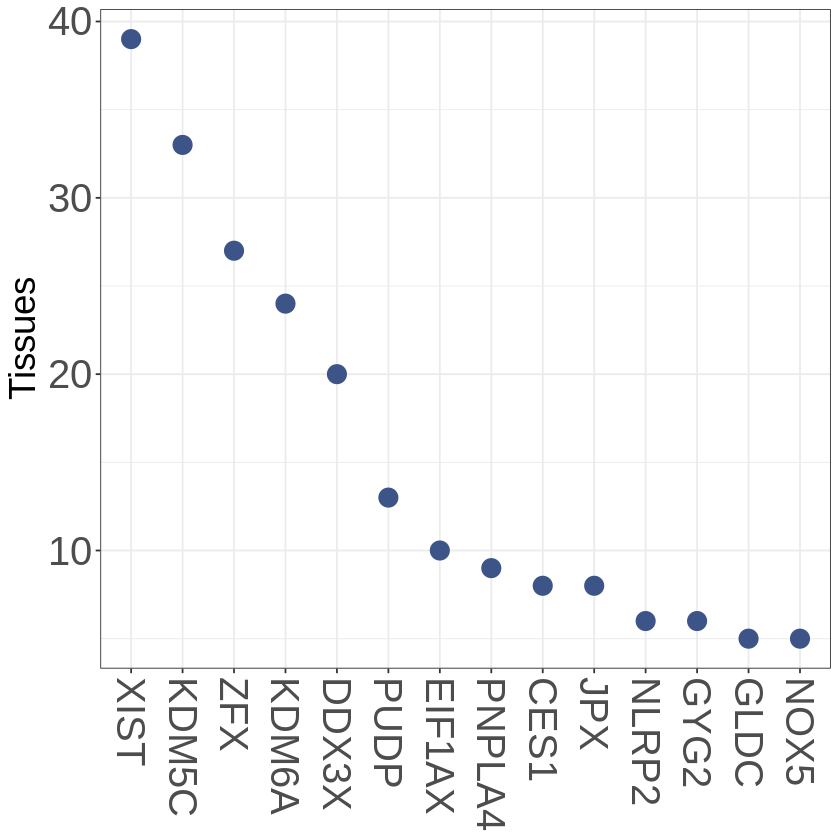

In [85]:
g <- ggplot(sorted_res, aes(x = reorder(GeneSymbol,-Tissues), y = Tissues)) +
  geom_point(colour = darkblue, size = 5) +
  theme_bw() +
  theme(axis.text.x = element_text(size=24, angle = 270, hjust = 0.0, vjust = 0.5),
        axis.text.y = element_text(size=24),
        axis.title.x = element_blank(),
        axis.title.y = element_text(face="plain", colour="black", size=22),
        legend.title=element_blank(),
        legend.position = "none" ) +
  ylab(paste("Tissues"))
ggsave("../pdf/AS_events_per_gene.pdf",g)
message("Saved plot as ../pdf/AS_events_per_gene.pdf")
g

### 3.11 Pie chart
Show recurrent vs unique splicing events with a piechart.

Tissue specific 1 tissue
Tissue group 2-5 tissues
Recurrent > 5 tissues

In [67]:
#Pie chart - Number of patients with 0, 1, >1 events
counts <- c(res %>% filter(Tissues == 1) %>% count() %>% as.numeric(),
            res %>% filter(Tissues > 1 & Tissues < 6) %>% count() %>% as.numeric(),
            res %>% filter(Tissues > 5) %>% count() %>% as.numeric())

In [68]:
piecolors <- c(darkblue,red,orange)

Calculate the percentage for each category

In [69]:
counts_labels <- round(counts/sum(counts) * 100, 1)
counts_labels <- paste("(",counts_labels,")", "%", sep="")
counts_labels <- paste(counts, counts_labels,sep =" ")

png 
  2

Wrote file to ../pdf/tissue-piechart.pdf



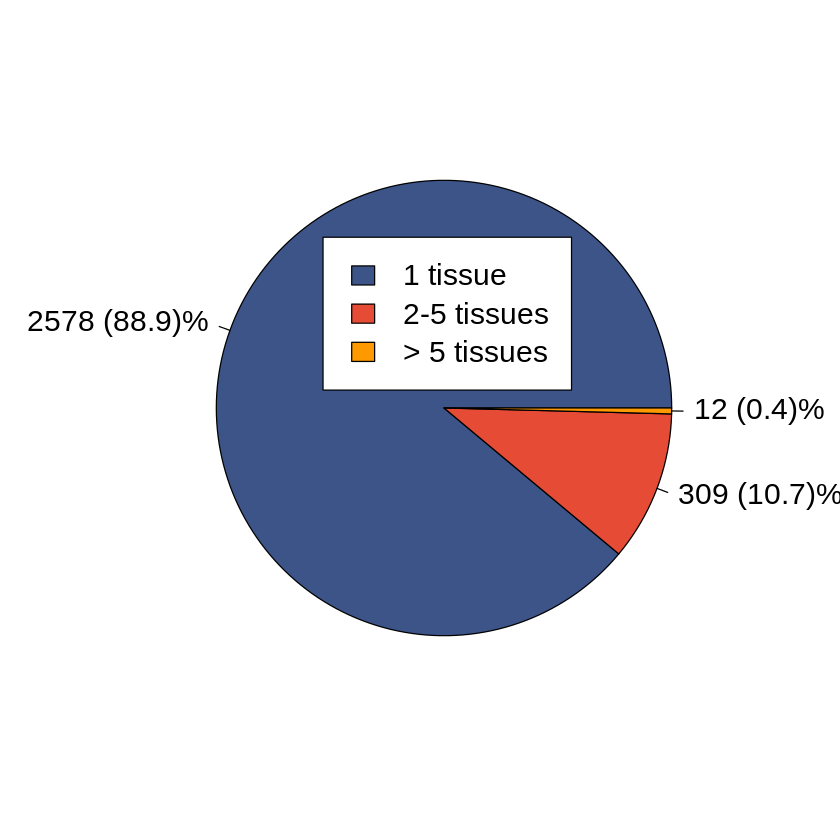

In [70]:
pdf("../pdf/tissue-piechart.pdf")
pie(counts, main="", col=piecolors, labels=counts_labels, cex=1.5)
# Create a legend at the right   
legend(-.425,0.6, c("1 tissue","2-5 tissues","> 5 tissues"), cex=1.5, 
       fill=piecolors, bg="white")
dev.off()
message("Wrote file to ../pdf/tissue-piechart.pdf")
pie(counts, main="", col=piecolors, labels=counts_labels,
    cex=1.5)
# Create a legend at the right   
legend(-.425,0.6, c("1 tissue","2-5 tissues","> 5 tissues"), cex=1.5, 
       fill=piecolors, bg="white")

In [87]:
message("Genes with DAS in 1 tissue ", counts[0])
counts

Genes with DAS in 1 tissue 



[1] 2578  309   12

### 3.12 Count most frequent spliced chromosomes
To get an indication of which chromosome has the most frequent slicing event (regardless of type)
We create an index based upon the number of exons per chromosome.

get the annotation file, at this writing, gencode.v30.annotation.gtf
The information as to the number of exons within the chromosome may be found there

In [71]:
if (!("GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm.gct" %in% list.files("../data/"))) {
    message("downloading gencode v30 annotation\n")
    system("wget -O ../data/gencode.v30.annotation.gtf.gz ftp://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_30/gencode.v30.annotation.gtf.gz")
    message("Done!\n")
    message("Unzipping compressed file gencode.v30.annotation.gtf.gz..")
    system("gunzip ../data/gencode.v30.annotation.gtf.gz", intern = TRUE)
    message("Done! gencode.v30.annotation.gtf can be found in ../data/")
}
gencode <- import("../data/gencode.v30.annotation.gtf")

downloading gencode v30 annotation


Done!


Unzipping compressed file gencode.v30.annotation.gtf.gz..

Warning message in system("gunzip ../data/gencode.v30.annotation.gtf.gz", intern = TRUE):
“running command 'gunzip ../data/gencode.v30.annotation.gtf.gz' had status 2”
Done! gencode.v30.annotation.gtf can be found in ../data/



In [75]:
exons <- gencode[ gencode$type == "exon", ]
exons <- as.data.frame(exons)

#Obtain chromosomes we have splicing information for (recall we did not use chr Y in our analysis)
all_chr <- as.character(unique(gene_as$chr))
chr_counts <- rep(0, length(all_chr))


for (i in 1:length(all_chr)) {
  chr_counts[i] <- nrow(exons[exons$seqnames == all_chr[i], ])
}

exon_counts <- data.frame(chr = all_chr, counts = chr_counts)

# Count most frequent spliced chromosomes
res <- gene_as %>% group_by(chr) %>% count(chr) %>% arrange(desc(n)) %>% as.data.frame()
res$chr <- factor(res$chr, levels = res$chr)

idx <- match(res$chr, exon_counts$chr)

res$ExonCounts <- exon_counts$counts[idx]

res$Index <- (res$n / res$ExonCounts) * 1000

res_sorted <- res %>% arrange(desc(Index))
res_sorted$chr <- factor(res_sorted$chr, levels = res_sorted$chr)
glimpse(res_sorted)
message("res_sorted has ", length(res_sorted$chr), " chromosomes with data about events, exons, and the splicing index")

Observations: 23
Variables: 4
$ chr        <fct> chrX, chr22, chr19, chr4, chr1, chr11, chr16, chr3, chr17,…
$ n          <int> 762, 168, 433, 290, 631, 388, 305, 381, 360, 215, 333, 248…
$ ExonCounts <dbl> 40029, 28655, 74466, 50420, 118996, 75976, 61199, 81519, 7…
$ Index      <dbl> 19.036199, 5.862851, 5.814734, 5.751686, 5.302699, 5.10687…


res_sorted has 23 chromosomes with data about events, exons, and the splicing index



Saving 6.67 x 6.67 in image

Saved plot as ../pdf/splicingIndex.pdf



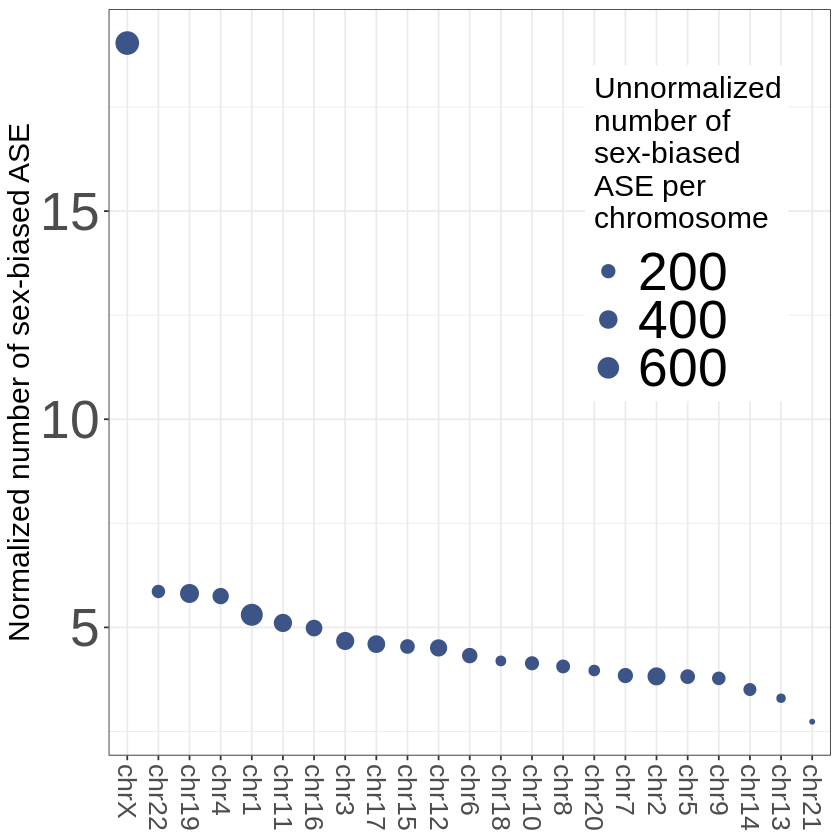

In [84]:
g2 <- ggplot(res_sorted, aes(x = chr, y = Index, size = n)) +
  geom_point(color = darkblue) +
  theme_bw() +
  theme(axis.text.x = element_text(size=16, angle = 270, hjust = 0.0, vjust = 0.5),
        axis.text.y = element_text(size=32),
        axis.title.x = element_blank(),
        axis.title.y = element_text(face="plain", colour="black", 
                                    size=18),
        legend.title=element_text(face="plain", colour="black", 
                                    size=18),
        legend.text = element_text(face="plain", colour="black", 
                                   size=32),
        legend.position = c(0.8, 0.7)) +
  scale_fill_viridis_c(aesthetics = c("colour", "fill"),
                       option = "plasma",
                       limits = c(1, 650)) +
  ylab(paste("Normalized number of sex-biased ASE")) +
  guides(size = guide_legend(title = "Unnormalized\nnumber of\nsex-biased\nASE per\nchromosome"))
ggsave("../pdf/splicingIndex.pdf",g2)
message("Saved plot as ../pdf/splicingIndex.pdf")
g2

In [ ]:
write.table(data,       file = "../data/Significant_AS_events.tsv", sep = "\t", row.names = F, quote = F)
write.table(res_sorted, file = "../data/SplicingIndex_chr.tsv", sep = "\t", quote = F, row.names = F)

### Appendix - Metadata

For replicability and reproducibility purposes, we also print the following metadata:

1. Checksums of **'artefacts'**, files generated during the analysis and stored in the folder directory **`data`**
2. List of environment metadata, dependencies, versions of libraries using `utils::sessionInfo()` and [`devtools::session_info()`](https://devtools.r-lib.org/reference/session_info.html)

### Appendix 1. Checksums with the sha256 algorithm

In [ ]:
rm (notebookid)
notebookid   = "countGenesAndEvents"
notebookid

message("Generating sha256 checksums of the file `../data/Total_AS_by_tissue.tsv` directory .. ")
system(paste0("cd ../data && find . -name SplicingIndex_chr.tsv -exec sha256sum {} \\;  >  ../metadata/", notebookid, "_sha256sums.txt"), intern = TRUE)
message("Done!\n")

message("Generating sha256 checksums of the file `../data/Significant_events.tsv` directory .. ")
system(paste0("cd ../data && find . -name SplicingIndex_chr.tsv -exec sha256sum {} \\;  >  ../metadata/", notebookid, "_sha256sums.txt"), intern = TRUE)
message("Done!\n")

message("Generating sha256 checksums of the file `../data/Significant_events.tsv` directory .. ")
system(paste0("cd ../data && find . -name SplicingIndex_chr.tsv -exec sha256sum {} \\;  >  ../metadata/", notebookid, "_sha256sums.txt"), intern = TRUE)
message("Done!\n")


paste0("../metadata/", notebookid, "_sha256sums.txt")

data.table::fread(paste0("../metadata/", notebookid, "_sha256sums.txt"), header = FALSE, col.names = c("sha256sum", "file"))

### Appendix 2. Libraries metadata

In [ ]:
dev_session_info   <- devtools::session_info()
utils_session_info <- utils::sessionInfo()

message("Saving `devtools::session_info()` objects in ../metadata/devtools_session_info.rds  ..")
saveRDS(dev_session_info, file = paste0("../metadata/", notebookid, "_devtools_session_info.rds"))
message("Done!\n")

message("Saving `utils::sessionInfo()` objects in ../metadata/utils_session_info.rds  ..")
saveRDS(utils_session_info, file = paste0("../metadata/", notebookid ,"_utils_info.rds"))
message("Done!\n")

dev_session_info$platform
dev_session_info$packages[dev_session_info$packages$attached==TRUE, ]